In [1]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import networkx as nx
import time

import tensorflow as tf
from tensorflow import keras

# %matplotlib notebook

In [2]:
class Distributed_System():
    def __init__(self, N, L):
        np.random.seed(41)
        self.N = N
        self.L = L
        
        # Variables: x , y (positions of agents in plan)
        self.x = np.random.rand(N)*L           # Initialize xᵢ
        self.y = np.random.rand(N)*L           # Initialize yᵢ
        
        self.r = np.ones(N)                    # Wave sending radius
        self.A = np.zeros((N,N))               # Adjacency Matrix
        self.k = np.zeros(N)                   # 
        for i in range(N):
            for j in range(i+1,N):
                if ( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5 < self.r[i]:
                    self.A[i][j] = self.A[j][i] = 1
                    self.k[i]   += self.A[i][j]
                    
            
    def step(self, i, r):
        H_t = self.Hamiltonian(i)
        
        self.A[i][:] = 0
        self.r[i] = r
        self.k[i] = 0
        mean_r_ij = 0
        
        for j in range(self.N):
            if i != j:
                distance = ( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5
                if distance  < self.r[i]:
                    self.A[i][j] = self.A[j][i] = 1;

                    self.k[i] += 1
                    mean_r_ij += distance
                
        H_t1 = self.Hamiltonian(i)
        reward = H_t - H_t1
        
        return ([ self.k[i], self.r[i], mean_r_ij/(self.k[i]+1e-10) ], reward)
        
        
    def Hamiltonian(self, i):
        alfa_1 = -0.5
        alfa_2 = +0.001
        alfa_3 = +0.5
        alfa_4 = -1
        
        fourth = np.zeros(self.N)
        for j in range(self.N):
            if i != j:
                fourth[i] += (self.A[i][j] / (( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5 ))
            
        H = alfa_1*self.k[i]**2 + alfa_2*self.k[i]**3 + alfa_3*self.r[i]**2 + alfa_4*fourth[i]
#         print(H)
        return H
    
    

    def Plot(self):
        fig, ax = plt.subplots()
        options = { 'node_size': 60, 'width': 0.3 }
        
        G = nx.from_numpy_array(self.A)
        for i in range(self.N):
            G.add_node(i, pos=(self.x[i], self.y[i]))
        pos = nx.get_node_attributes(G,'pos')
        
        nx.draw_networkx(G, pos, with_labels=False, **options)
        
        
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # turn the axis on
        plt.xlim(-0.1, self.L+0.1); plt.ylim(-0.1, self.L+0.1);
        plt.grid(alpha = 0.3);
        plt.show()

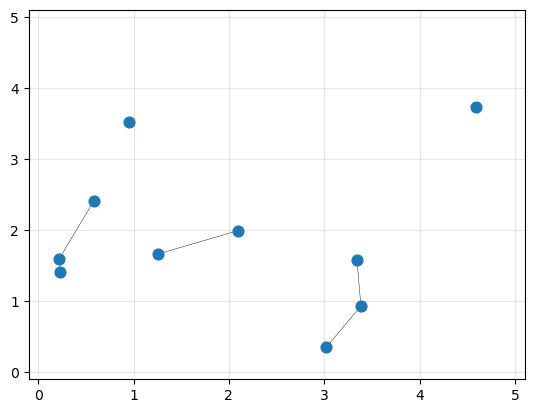

In [3]:
N = 10                      # Number of agents
L = 5                       # The length of the simulation box

env = Distributed_System(N,L)
env.Plot()

In [4]:
tf.random.set_seed(41)
np.random.seed(41)

input_shape = [3]              # == env.observation_space.shape
n_outputs = 1                  # == env.action_space.n

model = []
for i in range(N):
    model.append(keras.models.Sequential([
        keras.layers.Dense(12, activation="elu", input_shape=input_shape),
        keras.layers.Dense(10, activation="elu"),
        keras.layers.Dense(n_outputs)
    ]))
    
# model[1].layers
# hidden1 = model[0].layers[1]
# wieghts, biases = hidden1.get_weights()
# wieghts.shape

In [5]:
from collections import deque
replay_memory = []
for i in range(N):
    replay_memory.append(deque(maxlen=2000))

def play_one_step(env, i, state, epsilon=0):
    
    if np.random.rand() < epsilon:
        action = np.random.rand(n_outputs)*L
    else:
        action = model[i].predict(np.reshape(state, (3)).reshape(1, -1), verbose=0)[0]
#     print(i, state, action)
    
    
    next_state, reward = env.step(i, action)
    replay_memory[i].append((state, action, reward, next_state))
    return next_state, reward

In [8]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.1)
loss_fn = keras.losses.mean_squared_error

def training_step(i, batch_size):
    indices = np.random.randint(len(replay_memory[i]), size=batch_size)   # 32ta random number between[0 - len(replay)]
    batch   = [replay_memory[i][index] for index in indices]              # number in replay_memory[indices]
    
    states, actions, rewards, next_states = [                             # from replay_memory read these and save in...
        np.array([experience[field_index] for experience in batch])
        for field_index in range(4)]
    
     
    next_Q_values   = model[i].predict(next_states, verbose=0)            # 32 predict of 2 actions
    target_Q_values = (rewards + discount_rate*next_Q_values)             # Equation 18-5. Q-Learning algorithm
    
    with tf.GradientTape() as tape:
        Q_values = model[i](states)
#         Q_values = tf.reduce_sum(all_Q_values*mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model[i].trainable_variables)
    optimizer.apply_gradients(zip(grads, model[i].trainable_variables))

Episode: 0, Radius[1]: 1.2442021616791354, eps: 1.000

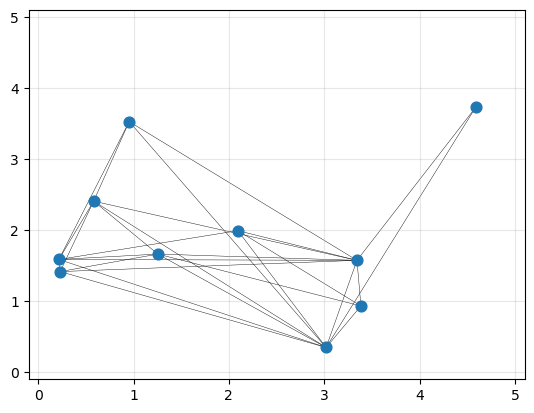

Episode: 100, Radius[1]: 1.0065190720750246, eps: 0.800

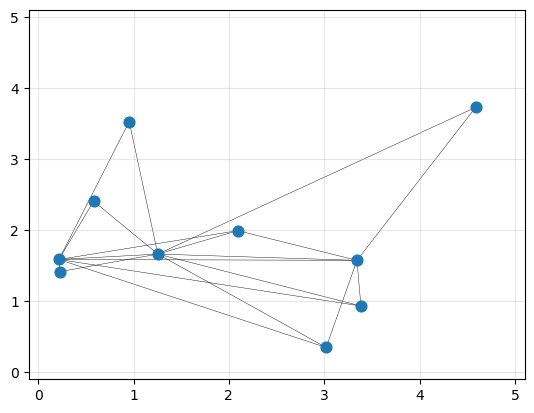

Episode: 200, Radius[1]: nan, eps: 0.600925, eps: 0.6048

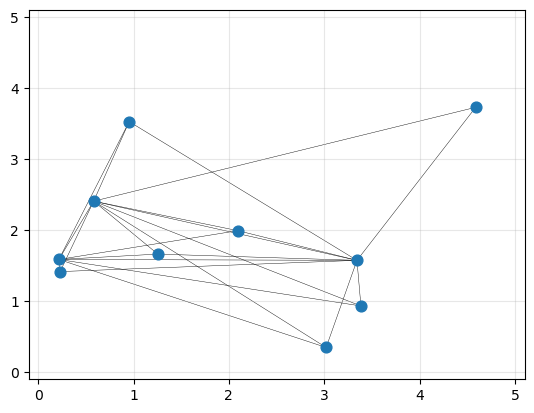

Episode: 300, Radius[1]: nan, eps: 0.40058, eps: 0.40644

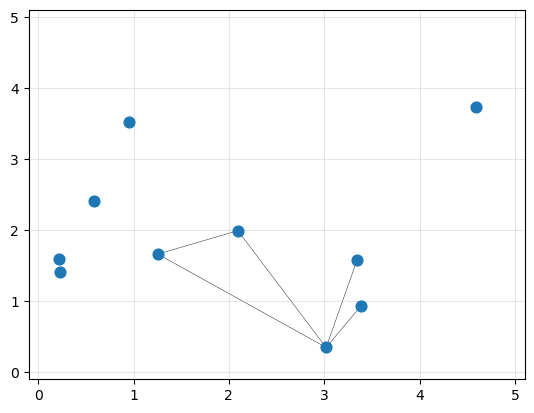

Episode: 400, Radius[1]: nan, eps: 0.20024, eps: 0.202212

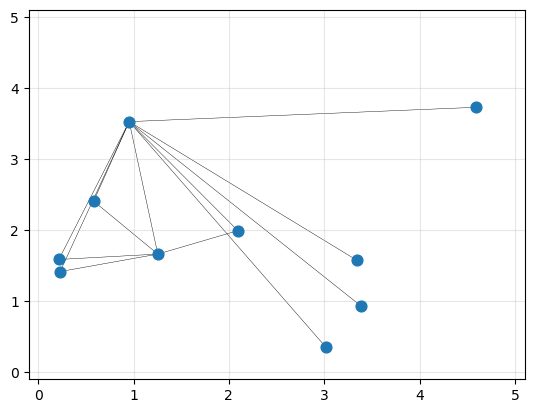

Episode: 500, Radius[1]: nan, eps: 0.01075, eps: 0.06642

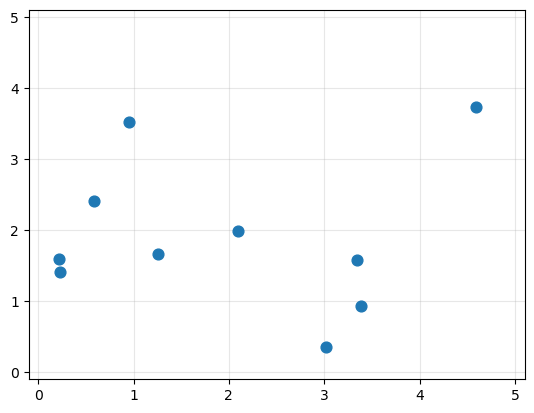

Episode: 600, Radius[1]: nan, eps: 0.010

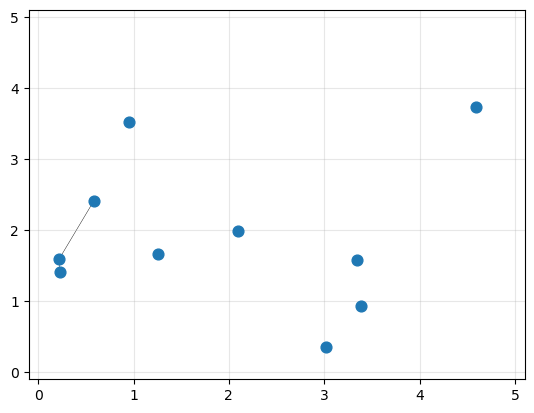

6143.443379640579


In [9]:
state  = []
reward = []
for i in range(N):
    state.append(env.step(i, 1)[0])
    reward.append(env.step(i, 1)[1])

    
start = time.time()
for episode in range(601):
    for i in range(N):
        state[i] = env.step(i, 1)[0]
    epsilon = max(1 - episode/500, 0.01)            # first is more random and than use greedy
    
    for step in range(20):
        for i in range(N):
            state[i], reward[i] = play_one_step(env, i, state[i], epsilon)
        
#     rewards.append(step)                   # Not shown in the book (just for polt)
#     if step >= best_score:                 # Not shown
#         best_weights = model.get_weights() # Not shown
#         best_score = step                  # Not shown

    print("\rEpisode: {}, Radius[1]: {}, eps: {:.3f}".format(episode, env.r[1], epsilon), end="") # Not shown
    if episode > 50:
        for i in range(N):
            training_step(i, batch_size)
        
    if episode%100 == 0:
        env.Plot()
        
end = time.time()    
print(end - start)

# for i in range(N):
#     model[i].set_weights(best_weights)